## Agenda:
  * **Regularization: Lasso Regression (L1 regularization for Logistic Regression)**
  * **Regularization: Ridge Regression (L2 regularization for Logistic Regression)**
  * **Regularization: Elastic Net Regression (L1 and L2 combined regularization for Logistic Regression)**

Now we are going to talk about what happens when we have lots of predictor variables (columns/features), and are trying to both generate accurate models, and reduce the number of features we use to predict/explain what is going on in our dataset.

We may need to do this for a variety of reasons.

In many instances, the number of columns you have in your data can be much larger than the number of samples (examples/rows) you have, this is especially the case with neuroscientific data where the number of channels/sensors is usually much, much larger than the number of trials you have (think of voxels in an ROI or channels for an EEG or MEG rig). One unfortunate result of this can be that we **overfit** our models (many different combinations of the columns in our data can generate the same training results). We need a systematic way to reduce the number of columns we use in our models to just those columns that are the most important for our prediction.

In general, not all of the columns in our dataset may be critical for predicting a given outcome variable because:

1. Several columns may be highly correlated with each other (provide redundant information) and with the outcome variable.
2. Columns may not be correlated at all with the outcome attribute (have no "predictive ability" in terms of what you're trying to predict).

One common strategy for dealing with both of these cases is called and **Regularization.**

By the end of this lesson you will be able to:

  * use Lasso/L1 regularization for both feature selection and general regression/classification problems
  * use Ridge/L2 regularization for regression and classification problems
  * explain the difference between L1/L2 regularization

In [1]:
#data handling, model creation/evaluation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LogisticRegression, ElasticNet
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
import scipy.stats as stats

# visualization
%matplotlib inline
import seaborn as sns

We are going to use our [chronic kidney disease dataset](http://archive.ics.uci.edu/ml/datasets/Housing) to explore Regularization.

Recall the dataset attributes:

* **age**: subject age, numeric
* **bp**: blood pressure,  numeric
* **sg**: specific gravity, numeric but discrete
* **al**: albumin, numeric but discrete
* **su**: sugar, numeric but discrete
* **rbc**: red blood cells, categorical
* **pc**: pus cell, categorical 
* **pcc**: pus cell clumps, categorical
* **ba**: bacteria, categorical
* **bgr**: blood glucose random, numeric
* **bu**: blood urea, numeric
* **sc**: serum creatinine, numeric 
* **sod**: sodium, numeric 
* **pot**: potassium, numeric 
* **hemo**: hemoglobin, numeric
* **pcv**: packed cell volume, numeric
* **wc**: white blood cell count, numeric
* **rc**: red blood cell count, numeric
* **htn**: hypertension, categorical
* **dm**: diabetes mellitus, categorical 
* **cad**: coronary artery disease, categorical
* **appet**: appetite, categorical
* **pe**: pedal edema, categorical 
* **ane**: anemia, categorical
* **class**: class, categorical
  
Let's load the data in and preprocess as we have in the past:

In [2]:
kidney_columns = ["age","bp","sg","al","su","rbc","pc","pcc","ba",
                  "bgr","bu","sc","sod","pot","hemo","pcv","wc","rc",
                  "htn","dm","cad","appet","pe","ane","class"]
kidney_data = pd.read_csv("../data/chronic_kidney_disease.csv", names=kidney_columns,na_values="?")
kidney_data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [3]:
kidney_columns = kidney_columns[:5]+kidney_columns[9:18]+kidney_columns[5:9]+kidney_columns[18:]
kidney_data = kidney_data[kidney_columns]
kidney_data.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,normal,notpresent,notpresent,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,normal,notpresent,notpresent,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,abnormal,present,notpresent,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,normal,notpresent,notpresent,no,no,no,good,no,no,ckd


In [4]:
#1. for the categorical data
#function to return the most frequent value in a pandas Series
def get_most_frequent_value(my_column):
    return my_column.value_counts().index[0]

most_frequent_values_per_column = kidney_data[kidney_columns[14:-1]].apply(get_most_frequent_value,axis=0)
categorical_most_frequent = kidney_data[kidney_columns[14:-1]].fillna(most_frequent_values_per_column,axis=0)

In [5]:
#2. this is where we will replace categoricals with values
no_map = {"no":0,"yes":1}
norm_map = {"normal":0,"abnormal":1}
pres_map = {"notpresent":0,"present":1}
good_map = {"poor":0,"good":1}

In [6]:
categorical_most_frequent.replace(no_map,inplace=True)
categorical_most_frequent.replace(norm_map,inplace=True)
categorical_most_frequent.replace(pres_map,inplace=True)
categorical_most_frequent.replace(good_map,inplace=True)
categorical_most_frequent.dm.replace(" yes",1,inplace=True)
categorical_most_frequent.head()

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane
0,0,0,0,0,1,1,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,1
3,0,1,1,0,1,0,0,0,1,1
4,0,0,0,0,0,0,0,1,0,0


In [7]:
#1. for the numeric data
median_per_column = kidney_data[kidney_columns[:14]].apply(lambda x: x.median(),axis=0)
numeric_median_filled = kidney_data[kidney_columns[:14]].fillna(median_per_column,axis=0)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #create a scaler object
scaler.fit(numeric_median_filled) #fit the scaler
numeric_scaled = scaler.transform(numeric_median_filled) #transform the data with it
numeric_scaled = pd.DataFrame(numeric_scaled,columns=kidney_columns[:14])

In [9]:
cleaned_kidney_data = pd.concat((numeric_scaled,categorical_most_frequent),axis=1)
cleaned_kidney_data["target"] = (kidney_data["class"]=="ckd").astype(int)

Lets take a look:

In [10]:
cleaned_kidney_data.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,target
0,-0.210031,0.254214,0.421486,0.076249,-0.380269,-0.320122,-0.419451,-0.319668,0.040104,-0.062903,...,0,0,0,1,1,0,1,0,0,1
1,-2.627234,-1.972476,0.421486,2.363728,-0.380269,-0.320122,-0.784315,-0.390819,0.040104,-0.062903,...,0,0,0,0,0,0,1,0,0,1
2,0.615355,0.254214,-1.421074,0.838742,2.507853,3.697618,-0.074858,-0.212942,0.040104,-0.062903,...,0,0,0,0,1,0,0,0,1,1
3,-0.210031,-0.488016,-2.342354,2.363728,-0.380269,-0.373337,-0.014047,0.142813,-2.896333,-0.737181,...,1,1,0,1,0,0,0,1,1,1
4,-0.033163,0.254214,-1.421074,0.838742,-0.380269,-0.519679,-0.622154,-0.284093,0.040104,-0.062903,...,0,0,0,0,0,0,1,0,0,1


And let's look at the correlation matrix:

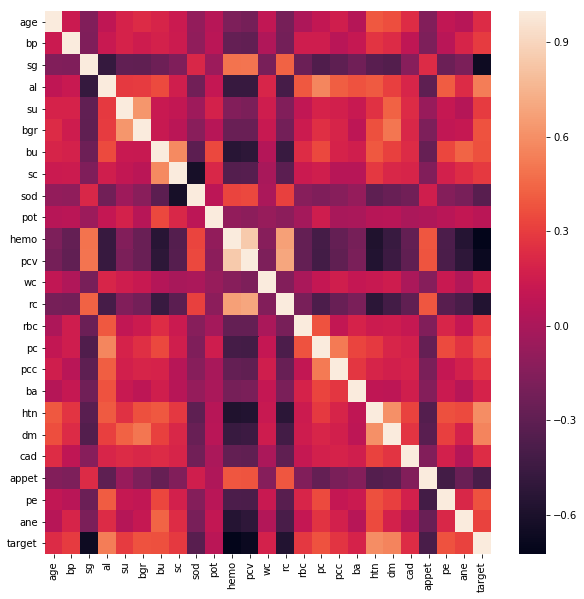

In [11]:
fig, ax = sns.mpl.pyplot.subplots(figsize=(10,10))
sns.heatmap(cleaned_kidney_data.corr(),ax=ax)

Notice how many of the features are very strongly correlated or anti-correlated with each other. High correlation among features is not ideal for building good predictive models. This will motivate our discussion of regularization.

* Multicollinearity obfuscates what is attributable to the model's predictive power.

Before we get into this, a brief aside on cross-validation as opposed to using a train/test split for model evaluation.

## Brief aside on cross-validation

There are drawbacks when just using a single train/test split.

**Specifically:**

Using one train/test split provides a high variance estimate since changing which observations happen to be in the testing set can significantly change testing accuracy.
What would be a better approach?

**Better approach:** Create a bunch of train/test splits, calculate the testing accuracy for each, and average the results together.

**This is the essense of cross-validation.**
![5 fold cv](../images/5-fold-cv.png)

Altnernative: **leave-one sample testing**
* when there is no obvious grouping
* leave one sample out and do a training and do a testing on that sample that was left out; repeat until all the samples are exhuasted

In [23]:
X,y = cleaned_kidney_data.iloc[:,:-1],cleaned_kidney_data.target

lr = LogisticRegression(C=1e8,random_state=1)

# test-set accuracy
cv_scores = cross_val_score(lr,X,y,
                            cv=10,
                            scoring='accuracy')

In [24]:
print("10 fold cv accuracy: {:0.3f}".format(cv_scores.mean()))

10 fold cv accuracy: 0.990


Pretty good accuracy!

Now let's see what the coefficients of a model trained on all of this data look like:

In [25]:
# refitting the logistic model on the entire test set
coeffs = LogisticRegression(C=1e8).fit(X,y).coef_

# data wrangling
coeff_df = pd.DataFrame(list(zip(cleaned_kidney_data.columns.tolist()[:-1],coeffs[0])),columns=["features","betas"])
coeff_df.sort_values("betas",ascending=False,inplace=True)
coeff_df

,features,betas
18,htn,12.581493
19,dm,11.526347
22,pe,10.371044
3,al,7.452525
5,bgr,6.624110
6,bu,6.529022
14,rbc,5.077182
7,sc,4.187178
15,pc,2.031988
16,pcc,1.550015


Now, let's try something else with this dataset to see if we can improve the overall predictive performance of our model.

Let's generate additional polynomial features up to degree 2 (all pairwise interactions among our original columns), and see if we can't improve the overall RMSE (by adding non-linearities that might be predictive apart from the linear features we've had so far):

In [28]:
from sklearn.preprocessing import PolynomialFeatures

In [29]:


#generate the transformer
pf_2 = PolynomialFeatures(degree=2,
                          interaction_only=True, # this excludes the polynomial of the terms (e.g., a^2, b^2)
                          include_bias=False) # ignore constant column

#apply it to the data, but ignore the first constant column
pf_2_data = pf_2.fit_transform(X)
print(pf_2_data.shape)

(400, 300)


In [30]:
lr = LogisticRegression(C=1e8,random_state=1)
#get the mean squared errors per fold, 10 fold cv
errors = cross_val_score(lr,pf_2_data,cleaned_kidney_data.target,cv=10,scoring="accuracy")
#convert each fold's mean squared errors to rmse
print("10-fold mean RMSE for degree-2 case: ",np.mean(errors))

10-fold mean RMSE for degree-2 case:  0.9599999999999997


So that model performed worse when we gave it non-linear features. Why would that happen? 2 reasons:

1. We are injection new columns that are highly correlated with our original columns, along with nonlinear information.
2. At this point, the number of columns in our dataset is very close to the number of samples we have. This is dangerously close to an over-specified model (too many unknowns relative to number of data points).

We generated interaction features and our accuracy went down marginally. How can we integrate the additional information from interaction terms, limit the impact of highly correlated features, and attempt to boost our model's performance?

**We can apply what is called REGULARIZATION!**

Regularization is a method for penalizing overly complicated models, while minimizing out-of-sample (test-set) error. We will talk about 2 kinds of regularization, which have different names, depending on whether they are being used for regression or classification:

 * **Lasso/L1 Regularization**
 * **Ridge/L2 Regularization**

In essence, regularization is a method for adding additional constraints or penalties to a model, with the goal of preventing overfitting and improving generalization.

### Lasso Regression / L1 Regularization for Logistic Regression

In traditional regression/classification, we try to minimize some kind of loss function (we try to make the loss be as close to 0 as possible). In regression, this is usually the **mean squared error** (or root mean squared error). However, with regularization, instead of just minimizing the loss based on the error of the model, we can also add a term that effectively "punishes" more complicated models.

What this means is that as you add more terms (features/columns) to your model, you suffer more added "loss due to complexity" in addition to "loss due to model performance." 

So, how can regularization be used in linear regression to effectively make models simpler?

**You reduce the coefficients for specific columns in your model until they go to zero (or very close to zero) for your model, which has the net effect of not using those features (or using them very sparingly)**

More mathematically, Lasso/L1 regularization adds an absolute-value penalty to the loss function:

$$loss_{lasso} = |Xw-Y|^2 + \lambda|w|$$

*lamda*: controls the strength of the regularization; varies between 0 - 1; serves as another parameter. 
*w*: magnitude of the coefficients. 

Whereas the non-regularized version is simply:

$$loss = |Xw-Y|^2$$

So, L1 regularization adds a penalty (based on $\lambda$) to the regular loss function. Since each non-zero coefficient adds to the penalty, it forces weak features to have zero as coefficients. Thus L1 regularization produces sparse solutions, inherently performing feature selection.

However, because this is an absolute value-based regularization (and absolute values are no-fun when it comes to taking derivatives), L1/Lasso regularization can lead to non-unique solutions (especially when you have highly correlated features...why?).

For classification, Scikit-learn requires that we use the `LogisticRegression` model with an additional parameter `penalty=l1`:

In [31]:
l1_all = LogisticRegression(penalty="l1",#increase the number of iterations for lasso to prevent lack of convergence
                            C=1) # C = 1 using regulariazation; C = 1e8 is not using regularization 

accuracies_poly2_lasso = cross_val_score(l1_all,
                                         pf_2_data,
                                         cleaned_kidney_data.target,
                                         cv=10,
                                         scoring="accuracy")

In [32]:
print("10-fold accuracy for degree-2 case, lasso regularization: {:0.03f}".format(np.mean(accuracies_poly2_lasso)))

10-fold accuracy for degree-2 case, lasso regularization: 0.990


That worked better than the full degree 2 model, but not better than the original.

Let's examine how many of the coefficients are non-zero when we fit on the full dataset:

In [33]:
lasso_all = LogisticRegression(C=1, penalty="l1").fit(pf_2_data,cleaned_kidney_data.target)
print("Number of features in the model: ",len(lasso_all.coef_[0]))
non_zero_features_mask = np.abs(lasso_all.coef_)>0.0001
print(non_zero_features_mask)
print("\n")
print("Number of non-zero features in the model: ",np.sum(non_zero_features_mask.astype(int)))
print("Fraction of total features used: ",float(np.sum(non_zero_features_mask.astype(int)))/len(lasso_all.coef_[0]))

Number of features in the model:  300
[[False  True  True  True False  True False  True  True False  True False
  False  True False False False False  True  True False False  True False
   True False False False  True False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False  True False False False False False
  False False False False False  True False False False False False False
  False False False  True False False False False False  True False False
  False  True False  True False False False False False False False  True
  False False False False False False False False  True False False False
  False False False False False False  True False False False False False
  False False False False False False False False False False False False
   True False False False False False False False False False False False


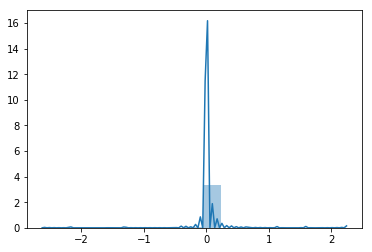

In [34]:
sns.distplot(lasso_all.coef_[0])

So, with full lasso regularization, we get a model that uses less than 30% of the 300 polynomial columns. A better example here would be to compare the coefficients of the original dataset with and without regularization:

In [35]:
X,y = cleaned_kidney_data.iloc[:,:-1],cleaned_kidney_data.target

lr = LogisticRegression(C=1e8)
lr_l1 = LogisticRegression(C=1,penalty="l1")
cv_scores_nol1 = cross_val_score(lr,X,y,cv=10,scoring='accuracy')
cv_scores_l1 = cross_val_score(lr_l1,X,y,cv=10,scoring='accuracy')

In [36]:
print("Full LR model, no regularization: {:0.3f}".format(np.mean(cv_scores_nol1)))
print("L1 penalized LR model, strong regularization: {:0.3f}".format(np.mean(cv_scores_l1)))

Full LR model, no regularization: 0.990
L1 penalized LR model, strong regularization: 0.982


Let's now compare the coefficients of both models, trained on all of the available data:

In [37]:
X,y = cleaned_kidney_data.iloc[:,:-1],cleaned_kidney_data.target

coeffs_noreg = LogisticRegression(C=1e8).fit(X,y).coef_[0]
coeffs_l1reg = LogisticRegression(penalty="l1",C=1).fit(X,y).coef_[0]
coeff_df = pd.DataFrame( list(zip(cleaned_kidney_data.columns.tolist()[:-1],
                                  coeffs_noreg,coeffs_l1reg)),
                        columns=["features","betas_noL1","betas_L1"])
coeff_df["beta_diffs"] = np.abs(coeff_df.betas_noL1) - np.abs(coeff_df.betas_L1)
coeff_df

,features,betas_noL1,betas_L1,beta_diffs
0,age,-1.490904,-0.008730,1.482174
1,bp,0.789970,0.169060,0.620910
2,sg,-15.075376,-2.483659,12.591717
3,al,7.452525,1.497404,5.955121
4,su,1.148232,0.469512,0.678720
5,bgr,6.624110,0.372465,6.251644
6,bu,6.529022,0.000000,6.529022
7,sc,4.187178,0.670444,3.516734
8,sod,1.457274,-0.304417,1.152857
9,pot,-8.450024,0.000000,8.450024


Notice that:

* Many coefficients are now effectively 0 (this means the column is not being used in the prediction)
* For those coefficients that still are being used, many of their magnitudes have gotten smaller
* Although we are using significantly fewer coefficients, our model's performance has not significantly suffered. We have effectively gotten a "simpler" model for relatively little cost.

#### Exercise Time!

 * Try the l1 regularization method but vary the `C` parameter. Inspect the coefficients and the cv-accuracy.

In [214]:
pass

### Ridge Regression / L2 Regularization for Logistic Regression

So, Lasso looks really excellent to use a regularization method. However, as I'd mentioned before, it is difficult to use across the board for all regression/classification problems, because it can create non-unique solutions, or solutions don't always converge (because of the problem with taking derivatives of a function that is not differentiable everywhere).

So, what can be done? We can create a penalty term that is smooth and therefore differentiable everywhere. Specifically, we can use what is called **Ridge/L2 regularization.** Here, the loss is slightly different:

$$loss_{ridge} = |Xw-Y|^2 + \lambda|w|^2$$

The act of squaring the weight features makes the penalty differentiable (because the values now smoothly transition to 0). So, squaring the L1 penalty turns it into an L2 penalty. **Square the Lasso and get a Ridge (or something).**

Since the coefficients are squared in the penalty expression, it has a different effect, namely it forces the coefficient values to be spread out more equally. For correlated features, it means that they tend to get similar coefficients (whereas in L1 regularization, one of the terms will usually be forced to 0).

**The effect of this is that models are much more stable (coefficients do not fluctuate on small data changes as is the case with unregularized or L1 models). So while Ridge/L2 regularization does not perform feature selection the same way as L1 does, it is much more useful for feature *interpretation*; a predictive feature will get a non-zero coefficient, which is often not the case with L1.**

Let's now use the full-penalty Ridge regression and see what happens:

In [38]:
ridge = LogisticRegression(penalty="l2",C=1)
ridge_cv_accuracies = cross_val_score(ridge,
                                      cleaned_kidney_data.iloc[:,:-1],
                                      cleaned_kidney_data.target,
                                      cv=10,
                                      scoring="accuracy")
print("10-fold mean accuracy, strong ridge regularization: ",np.mean(ridge_cv_accuracies))

10-fold mean accuracy, strong ridge regularization:  0.9949999999999999


Lets compare the accuracies of the 3 models:

In [39]:
lr = LogisticRegression(C=1e9)
l1 = LogisticRegression(penalty="l1",C=1)
l2 = LogisticRegression(penalty="l2",C=1)

lr_accs = cross_val_score(lr,
                          cleaned_kidney_data.iloc[:,:-1],
                          cleaned_kidney_data.target,
                          cv=10,
                          scoring="accuracy")
l1_accs = cross_val_score(l1,
                          cleaned_kidney_data.iloc[:,:-1],
                          cleaned_kidney_data.target,
                          cv=10,
                          scoring="accuracy")
l2_accs = cross_val_score(l2,
                          cleaned_kidney_data.iloc[:,:-1],
                          cleaned_kidney_data.target,
                          cv=10,
                          scoring="accuracy")

In [40]:
print(np.mean(lr_accs)) # original model
print(np.mean(l1_accs)) # penalizing smaller terms (L1 regularization)
print(np.mean(l2_accs)) # smoothing (L2 regulazation)

0.99
0.985
0.9949999999999999


We can compare the fitted coefficients for each of the 3 models:

In [41]:
X,y = cleaned_kidney_data.iloc[:,:-1],cleaned_kidney_data.target

coeffs_noreg = LogisticRegression(C=1e8).fit(X,y).coef_[0]
coeffs_l1reg = LogisticRegression(penalty="l1",C=1).fit(X,y).coef_[0]
coeffs_l2reg = LogisticRegression(penalty="l2",C=1).fit(X,y).coef_[0]
coeff_df = pd.DataFrame(list(zip(cleaned_kidney_data.columns.tolist()[:-1],
                                 coeffs_noreg,
                                 coeffs_l1reg, 
                                 coeffs_l2reg)),
                        columns=["features","betas","betas_L1","betas_L2"])
coeff_df

,features,betas,betas_L1,betas_L2
0,age,-1.490904,-0.008182,-0.230692
1,bp,0.789970,0.168701,0.343276
2,sg,-15.075376,-2.484992,-1.897266
3,al,7.452525,1.495728,1.096099
4,su,1.148232,0.469074,0.593027
5,bgr,6.624110,0.372945,0.542160
6,bu,6.529022,0.000000,0.157599
7,sc,4.187178,0.668117,0.882907
8,sod,1.457274,-0.305794,-0.545554
9,pot,-8.450024,0.000000,-0.267640


However, keep in mind that you can alter the amount of regularization ($\lambda$) you want by altering the `C` parameter for the LR model.

**The higher the `C` the lower the regularization (this is why I always made the `C` parameter obscenely high before, so that the `Logistic Regression` was always un-regularized.**

You can combine both `L1` and `L2` penalties together into another classifer called an `ElasticNet`. Furthermore, you can use sklearn to automatically find an ideal regularization value for you using either the `ElasticNetCV` or `LogisticRegressionCV` classes.

However, if you want to use the `ElasticNet` classifier inside of other scikit learn functions, you must use the `SGDClassifier` class instead:

In [42]:
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV, SGDClassifier

l1_ratios = np.arange(0.01,1,.05)
enet = ElasticNetCV(cv=10,l1_ratio=l1_ratios)
enet.fit(cleaned_kidney_data.iloc[:,:-1],cleaned_kidney_data.target)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]),
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [43]:
enet.alpha_

0.00686385860772757

In [44]:
enet.l1_ratio_

0.9600000000000001

In [45]:
enet.coef_

array([ 0.        ,  0.02382838, -0.15455025,  0.04316651,  0.        ,
        0.01981542, -0.02404562,  0.00886937, -0.01777904,  0.        ,
       -0.1759993 , -0.00629706,  0.        , -0.00096261,  0.        ,
       -0.        , -0.        , -0.        ,  0.09784247,  0.11797168,
       -0.        , -0.03497379,  0.        , -0.        ])

In [46]:
enet_coeff_df = pd.DataFrame(list(zip(cleaned_kidney_data.columns.tolist()[:-1],
                                      enet.coef_,np.abs(enet.coef_))),
                             columns=["features","betas_enet","abs_betas"])
enet_coeff_df.sort_values("abs_betas",inplace=True,ascending=False)

In [47]:
enet_coeff_df

,features,betas_enet,abs_betas
10,hemo,-0.175999,0.175999
2,sg,-0.154550,0.154550
19,dm,0.117972,0.117972
18,htn,0.097842,0.097842
3,al,0.043167,0.043167
21,appet,-0.034974,0.034974
6,bu,-0.024046,0.024046
1,bp,0.023828,0.023828
5,bgr,0.019815,0.019815
8,sod,-0.017779,0.017779


In [251]:
best_enet = SGDClassifier(alpha=enet.alpha_,loss="log",penalty="elasticnet",l1_ratio=enet.l1_ratio_)

enet_accs = cross_val_score(best_enet,
                          cleaned_kidney_data.iloc[:,:-1],
                          cleaned_kidney_data.target,
                          cv=10,
                          scoring="accuracy")
print(np.mean(enet_accs))

0.9775


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:131: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:131: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:131: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

#### Exercise Time

* Use the `elastic net` regressor on the data and see if you can't find an ideal cross-validated combination of alpha and l1-ratio value for the model.

In [ ]:
pass

### Lasso vs. Ridge

#### Lasso:
* produces sparse models 
* is useful for strong feature selection in order to improve model performance, or to minimize the number of explanatory variables.
* can produce non-unique solutions (when some features are very strongly correlated)
* can produce very different solutions depending on slight changes in features (because of non-uniqueness)

#### Ridge:
* produces stable models with smooth non-zero coefficients across features. 
* is useful for data interpretation, understanding what features, even when correlated, may be used in combination to predict the response.
* may tell you something about how the data itself was generated.

You can combine both Lasso and Ridge models into a single penalized model (that uses a weighted combination of Lasso and Ridge regression). This is called the `ElasticNet`.

### General Strategy and Takeaways

* If you are trying for data explanation, use Ridge/L2 regularization
* If you are going for sparse models, use Lasso/L1, but realize that the solution may be non-unique. In general, Lasso doesn't always perform better than Ridge.
* `ElasticNet` requires significantly more tuning than either method, but can lead to the highest performing "linear" models.

**As always, with great power comes great responsibility, so use all of these methods wisely.**